## Problem Statement 

Building a model that is able to classify customer complaints based on the products/services. Segregating tickets help in the quick resolution of the issue.

Since this data is not labelled,applying NMF(Topic Modelling) to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 

## Steps performed:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [6]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [7]:
# Opening JSON file 
f = open("complaints-2021-05-14_08_16.json")
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [8]:
# Inspect the dataframe to understand the given data.
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [9]:
#Length of dataframe
print("Total entries in dataframe is :",len(df))

Total entries in dataframe is : 78313


In [10]:
#print the column names
existing_cols=list(df.columns)
print(existing_cols)

['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code', '_source.complaint_id', '_source.issue', '_source.date_received', '_source.state', '_source.consumer_disputed', '_source.product', '_source.company_response', '_source.company', '_source.submitted_via', '_source.date_sent_to_company', '_source.company_public_response', '_source.sub_product', '_source.timely', '_source.complaint_what_happened', '_source.sub_issue', '_source.consumer_consent_provided']


In [11]:
#Assign new column names
new_cols=[cols.replace("_source.","") for cols in existing_cols]
#new_cols = [cols.replace("_","",1) if cols[0]=="_" for cols in new_cols]
df.columns=new_cols
print("The new column names are : \n",list(df.columns))

The new column names are : 
 ['_index', '_type', '_id', '_score', 'tags', 'zip_code', 'complaint_id', 'issue', 'date_received', 'state', 'consumer_disputed', 'product', 'company_response', 'company', 'submitted_via', 'date_sent_to_company', 'company_public_response', 'sub_product', 'timely', 'complaint_what_happened', 'sub_issue', 'consumer_consent_provided']


In [12]:
#Assign nan in place of blanks in the complaints column
df["complaint_what_happened"] = df["complaint_what_happened"].apply(lambda x: str(x).strip()).replace('', np.nan)
blank_complaints=df['complaint_what_happened'].isna().sum()
print("The total blank complaints are : ",blank_complaints)

The total blank complaints are :  57241


In [13]:
#Remove all rows where complaints column is nan
new_df= df[df["complaint_what_happened"].notna()]
new_df.reset_index()
print("Length of dataframe after removing blank complaints :",len(new_df))

Length of dataframe after removing blank complaints : 21072


## Preparing the text for topic modeling

Removing blank complaints and doing following preprocessing steps:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


After cleaning operations, performing the following:
* Lemmatize texts
* Extract POS tags of the lemmatized text and removing all the words which have tags other than NN[tag == "NN"].


In [14]:
# Function to clean the text and remove all the unnecessary elements.
def preprocess_complaints(complaint):
    complaint=complaint.lower()
    complaint=re.sub("\[.*?\]","",complaint)
    complaint=re.sub(r'[^\w\s]', '', complaint)
    complaint=re.sub(r'\w*\d\w*', '', complaint).strip()
    return complaint    

In [15]:
#Function to Lemmatize the texts
nlp = spacy.load('en_core_web_sm')
def lemmatize(complaint):
    doc = nlp(complaint)
    lemma=[]
    for token in doc:
        lemma.append(token.lemma_)
    lemmatized_complaint=" ".join(lemma)
    return lemmatized_complaint

In [16]:
#Creating a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
from tqdm import tqdm
df_clean = new_df[["_id","complaint_what_happened"]].copy()
# Cleaning complaints
df_clean["cleaned_complaints"] = df_clean["complaint_what_happened"].apply(preprocess_complaints)
lemm_complaints = []
for complaint in tqdm(list(df_clean["cleaned_complaints"])):
    lemm_complaints.append(lemmatize(complaint))
df_clean["lemm_complaints"] = lemm_complaints

100%|██████████| 21072/21072 [16:02<00:00, 21.89it/s]


In [17]:
df_clean.head()

,_id,complaint_what_happened,cleaned_complaints,lemm_complaints
1,3229299,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,good morning -PRON- name be xxxx xxxx and i ap...
2,3199379,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and was told ...,i upgrade -PRON- xxxx xxxx card in and be te...
10,3233499,Chase Card was reported on XX/XX/2019. However...,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,3180294,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,3224980,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it i...,-PRON- grand son give -PRON- check for i dep...


In [18]:
#Function to extract the POS tags 

def pos_tag(text):
  doc = nlp(text)
  out = []
  for token in doc:
    if token.tag_ == "NN":
      out.append(token.text)
  return " ".join(out)

pos_removed = [pos_tag(text) for text in tqdm(lemm_complaints)]


df_clean["complaint_POS_removed"] =  pos_removed
 #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].

100%|██████████| 21072/21072 [13:04<00:00, 26.85it/s]


In [19]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean = df_clean[["complaint_what_happened","lemm_complaints","complaint_POS_removed"]]
df_clean.head()

,complaint_what_happened,lemm_complaints,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning name stop debt verification statement ...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgrade -PRON- xxxx xxxx card in and be te...,agent upgrade anniversary date agent informati...
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent a...,report application -PRON- identity consent ser...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket ...,xxxx ticket offer ticket reward card informati...
14,my grand son give me check for {$1600.00} i de...,-PRON- grand son give -PRON- check for i dep...,son account account money son check money mone...


## Exploratory data analysis to get familiar with the data.

*   Visualising the data according to the 'Complaint' character length
*   Using a word cloud to find the top 40 words by frequency among all the articles after processing the text
*   Finding the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘

c:\Users\Karthick\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



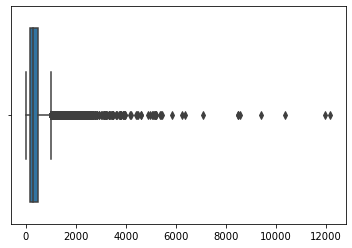

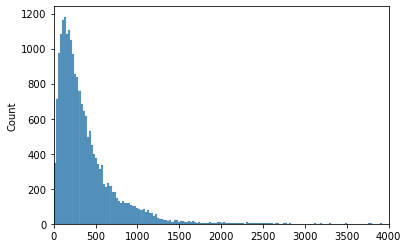

count    21072.000000
mean       386.069191
std        438.476465
min          0.000000
25%        144.000000
50%        272.000000
75%        485.000000
max      12171.000000
Name: char_length, dtype: float64

In [20]:
# Code to visualise the data according to the 'Complaint' character length
import seaborn as sb
import matplotlib.pyplot as plt
df_length = df_clean[["complaint_POS_removed"]].copy()
df_length["char_length"] = df_length["complaint_POS_removed"].apply(lambda x: len(str(x)))
length_comp=list(df_length["char_length"])
sb.boxplot(length_comp)
plt.show()
hist=sb.histplot(length_comp)
hist.set_xlim(0,4000)
plt.show()
df_length["char_length"].describe()

##### Observation : The maximum character length of complaint is 12160 and the average complaint length is 385 characters. Most of the complaints are within 500 characters

#### Finding the top 40 words by frequency among all the articles after processing the text.

The top frequent words with their frequency are :  [('chase', 14094), ('credit card', 12313), ('time', 8578), ('bank', 6174), ('information', 4978), ('PRON', 4661), ('day', 4541), ('issue', 4293), ('state', 4290), ('month', 3895), ('credit report', 3843), ('xxxx', 3643), ('PRON account', 3494), ('transaction', 3421), ('claim', 3361), ('company', 3330), ('money', 2905), ('customer service', 2820), ('year', 2803), ('amount', 2759), ('letter', 2735), ('customer', 2722), ('request', 2578), ('way', 2563), ('nothing', 2516), ('fraud', 2506), ('week', 2467), ('anything', 2467), ('point', 2457), ('person', 2447), ('case', 2441), ('email', 2391), ('someone', 2362), ('reason', 2356), ('today', 2345), ('fee', 2332), ('problem', 2311), ('order', 2307), ('process', 2300), ('fact', 2271)]


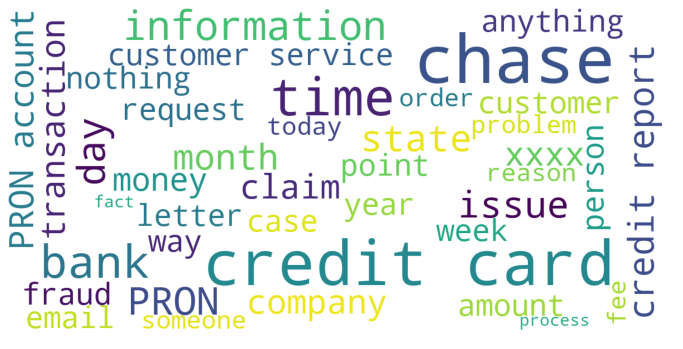

In [21]:
#Using a word cloud to find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    stopwords = set(STOPWORDS)
    data_all=" ".join(list(data))
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=40,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(data_all)
    
    text_dict=wordcloud.process_text(data_all)
    word_freq={k: v for k, v in sorted(text_dict.items(),reverse=True, key=lambda item: item[1])}
    print("The top frequent words with their frequency are : ",list(word_freq.items())[:40])
    
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

df_clean["complaint_POS_removed"] = df_clean["complaint_POS_removed"].astype(str)
show_wordcloud(df_clean["complaint_POS_removed"])

In [22]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Finding the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [23]:
#Code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
from nltk import ngrams,FreqDist
from collections import OrderedDict

complaint_all=" ".join(list(df_clean['Complaint_clean']))
print("Length of all complaints together",len(complaint_all))

def ngram_extract(data,n,top):
  ngram = ngrams(data.split(" "), n)
  #compute frequency distribution for all the bigrams in the text
  fdist = FreqDist(ngram)
  word_freq={k: v for k, v in sorted(fdist.items(),reverse=True, key=lambda item: item[1])}
  top_ngrams=list(word_freq.items())[:top]
  return OrderedDict(word_freq),top_ngrams
  
unigram_freq_dist,top_unigrams=ngram_extract(complaint_all,1,30)
print(f"The top 30 unigrams with their frequency are : {top_unigrams}")

Length of all complaints together 8045591
The top 30 unigrams with their frequency are : [(('account',), 44365), (('credit',), 32746), (('card',), 29294), (('chase',), 27251), (('payment',), 20881), (('',), 18470), (('charge',), 16032), (('time',), 15829), (('bank',), 14074), (('day',), 12636), (('money',), 11935), (('check',), 10862), (('loan',), 10320), (('information',), 9611), (('letter',), 9495), (('report',), 9119), (('fee',), 8579), (('number',), 8525), (('month',), 8435), (('amount',), 8388), (('transaction',), 8369), (('year',), 8065), (('call',), 8028), (('customer',), 7943), (('state',), 7847), (('balance',), 7677), (('mortgage',), 7595), (('phone',), 7578), (('claim',), 7493), (('company',), 7425)]


In [24]:
#Printing the top 10 words in the unigram frequency
def extract_top_words_fdist(fdist,top):
    words=list(fdist.keys())[:top]
    words=[" ".join(word) for word in words]
    return words

top_10_unigrams=extract_top_words_fdist(unigram_freq_dist,10)
print("The top 10 words by unigram frequency are : ",top_10_unigrams)

The top 10 words by unigram frequency are :  ['account', 'credit', 'card', 'chase', 'payment', '', 'charge', 'time', 'bank', 'day']


In [25]:
#Code to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
bigram_freq_dist,top_bigrams=ngram_extract(complaint_all,2,30)
print(f"The top 30 bigrams with their frequency are : {top_bigrams}")

The top 30 bigrams with their frequency are : [(('credit', 'card'), 12313), (('credit', 'report'), 3843), (('', 'account'), 3495), (('customer', 'service'), 2820), (('account', 'account'), 2151), (('debit', 'card'), 1844), (('bank', 'account'), 1752), (('checking', 'account'), 1707), (('credit', 'score'), 1705), (('phone', 'call'), 1633), (('account', 'chase'), 1585), (('card', 'account'), 1527), (('chase', 'credit'), 1481), (('account', 'credit'), 1458), (('payment', 'payment'), 1370), (('interest', 'rate'), 1288), (('phone', 'number'), 1240), (('chase', 'account'), 1232), (('business', 'day'), 1195), (('money', 'account'), 1147), (('account', 'number'), 1116), (('card', 'company'), 1102), (('check', 'account'), 1100), (('card', 'credit'), 1088), (('card', 'card'), 1085), (('charge', 'account'), 1047), (('mortgage', 'payment'), 1014), (('', 'card'), 996), (('loan', 'modification'), 969), (('report', 'credit'), 961)]


In [26]:
#Printing top 10 words in the bigram frequency
top_10_bigrams=extract_top_words_fdist(bigram_freq_dist,10)
print("The top 10 words by bigram frequency are : ",top_10_bigrams)

The top 10 words by bigram frequency are :  ['credit card', 'credit report', ' account', 'customer service', 'account account', 'debit card', 'bank account', 'checking account', 'credit score', 'phone call']


In [27]:
#Code to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
trigram_freq_dist,top_trigrams=ngram_extract(complaint_all,3,30)
print(f"The top 30 bigrams with their frequency are : {top_trigrams}")

The top 30 bigrams with their frequency are : [(('credit', 'card', 'account'), 958), (('chase', 'credit', 'card'), 948), (('credit', 'card', 'company'), 940), (('charge', 'credit', 'card'), 574), (('credit', 'card', 'credit'), 542), (('inquiry', 'credit', 'report'), 489), (('account', 'credit', 'card'), 475), (('card', 'credit', 'card'), 472), (('credit', 'card', 'chase'), 365), (('credit', 'reporting', 'agency'), 361), (('credit', 'card', 'charge'), 355), (('credit', 'report', 'credit'), 350), (('credit', 'reporting', 'act'), 331), (('credit', 'card', 'payment'), 306), (('credit', 'card', 'card'), 295), (('customer', 'service', 'representative'), 292), (('payment', 'credit', 'card'), 271), (('account', 'credit', 'report'), 269), (('victim', 'identity', 'theft'), 252), (('credit', 'card', 'balance'), 249), (('checking', 'saving', 'account'), 208), (('credit', 'card', 'statement'), 204), (('money', '', 'account'), 202), (('credit', 'card', 'year'), 201), (('report', 'credit', 'report'),

In [28]:
#Printing the top 10 words in the trigram frequency
top_10_trigrams=extract_top_words_fdist(trigram_freq_dist,10)
print("The top 10 words by trigram frequency are : ",top_10_trigrams)

The top 10 words by trigram frequency are :  ['credit card account', 'chase credit card', 'credit card company', 'charge credit card', 'credit card credit', 'inquiry credit report', 'account credit card', 'card credit card', 'credit card chase', 'credit reporting agency']


#### The personal details of customer has been masked in the dataset with xxxx. Removing the masked text as this will be of no use for our analysis

In [29]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [30]:
#All masked texts has been removed
df_clean.head()

,complaint_what_happened,lemm_complaints,complaint_POS_removed,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning name stop debt verification statement ...,morning name stop debt verification statement ...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgrade -PRON- xxxx xxxx card in and be te...,agent upgrade anniversary date agent informati...,agent upgrade anniversary date agent informati...
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent a...,report application -PRON- identity consent ser...,report application identity consent service c...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket ...,xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...
14,my grand son give me check for {$1600.00} i de...,-PRON- grand son give -PRON- check for i dep...,son account account money son check money mone...,son account account money son check money mone...


## Feature Extraction
Converting the raw texts to a matrix of TF-IDF features

In [31]:
#Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(max_df = 0.95,min_df = 2)

#### Creating a document term matrix using fit_transform

In [32]:
#Code to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])
dtm_df=pd.DataFrame(dtm.toarray(), columns=tfidf.get_feature_names_out())
print("The shape of document term matrix is ",dtm_df.shape)

The shape of document term matrix is  (21072, 6547)


## Topic Modelling using NMF
Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on

In [33]:
from sklearn.decomposition import NMF

In [34]:
#Loading nmf_model with the n_components i.e 5
num_topics = 5

nmf_model = NMF(n_components=num_topics,random_state=40)
W = nmf_model.fit_transform(dtm)  # Document-topic matrix
H = nmf_model.components_       # Topic-term matrix

In [35]:
#Fitting NMF model
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

6547

In [36]:
#Printing the Top15 words for each of the topics
tot_words=15
words = np.array(tfidf.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, tot_words)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(tot_words)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:tot_words]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,money,bank,fund,deposit,chase,branch,day,number,checking,transaction,business,transfer,claim
Topic 2,credit,card,report,inquiry,account,score,chase,company,information,limit,debt,application,letter,year,reporting
Topic 3,payment,balance,month,interest,statement,fee,amount,pay,day,time,date,bill,credit,auto,account
Topic 4,charge,card,fee,transaction,dispute,merchant,purchase,chase,interest,claim,amount,fraud,refund,service,time
Topic 5,loan,mortgage,modification,home,chase,property,letter,year,document,time,rate,foreclosure,sale,request,information


In [81]:
#Creating the best topic for each complaint in terms of integer value 0,1,2,3 & 4
#Topic 1 - Bank account services - (0)
#Topic 2 - Credit card / Prepaid card - (1)
#Topic 3 - Others - (2)
#Topic 4 - Theft/Dispute reporting - (3)
#Topic 5 - Mortgages/loans - (4)

topic_mapping = {
    'Topic 1': 0,
    'Topic 2': 1,
    'Topic 3': 2,
    'Topic 4': 3,
    'Topic 5': 4,
}

In [82]:
#Assigning the best topic to each of the complaints in Topic Column
W = pd.DataFrame(W, columns=[f'Topic {i + 1}' for i in range(num_topics)])
W['Topic'] = W.apply(lambda x: topic_mapping.get(x.idxmax()), axis=1)
W[pd.notnull(W['Topic'])].head(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic
0,0.008547,0.012795,0.007511,0.002875,0.025188,4
1,0.009616,0.003422,0.002204,0.003672,0.008250,0
2,0.000000,0.048182,0.000000,0.000000,0.002152,1
3,0.011649,0.067479,0.000000,0.000000,0.014009,1
4,0.058155,0.000000,0.000000,0.000000,0.000000,0
5,0.000000,0.052200,0.000000,0.000000,0.000000,1
6,0.060694,0.001740,0.013048,0.005144,0.009319,0
7,0.004735,0.004435,0.052516,0.001465,0.049624,2
8,0.028230,0.003965,0.001884,0.045858,0.026603,3
9,0.000000,0.112676,0.000000,0.000000,0.000000,1


In [83]:
df_clean.reset_index(inplace=True)
df_clean["Topic"]=W["Topic"]
df_clean.head()

,level_0,index,complaint_what_happened,lemm_complaints,complaint_POS_removed,Complaint_clean,Topic
0,0,1,Good morning my name is XXXX XXXX and I apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,4
1,1,2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgrade -PRON- xxxx xxxx card in and be te...,agent upgrade anniversary date agent informati...,agent upgrade anniversary date agent informati...,0
2,2,10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent a...,report application -PRON- identity consent ser...,report application identity consent service c...,1
3,3,11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket ...,xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...,1
4,4,14,my grand son give me check for {$1600.00} i de...,-PRON- grand son give -PRON- check for i dep...,son account account money son check money mone...,son account account money son check money mone...,0


In [85]:
#Printing the first 5 Complaint for each of the Topics
df_clean_group=df_clean.groupby('Topic').head(5)
df_clean_group.sort_values('Topic')

,level_0,index,complaint_what_happened,lemm_complaints,complaint_POS_removed,Complaint_clean,Topic
12,12,27,I opened an account with chase bank on XXXX an...,i open an account with chase bank on xxxx and ...,account code term everything account deposit b...,account code term everything account deposit b...,0
1,1,2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgrade -PRON- xxxx xxxx card in and be te...,agent upgrade anniversary date agent informati...,agent upgrade anniversary date agent informati...,0
4,4,14,my grand son give me check for {$1600.00} i de...,-PRON- grand son give -PRON- check for i dep...,son account account money son check money mone...,son account account money son check money mone...,0
6,6,17,With out notice J.P. Morgan Chase restricted m...,with out notice jp morgan chase restrict -PRON...,notice restrict account card branch advise cus...,notice restrict account card branch advise cus...,0
10,10,24,mishandling of this account by Chase auto and ...,mishandle of this account by chase auto and xxxx,account,account,0
2,2,10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent a...,report application -PRON- identity consent ser...,report application identity consent service c...,1
3,3,11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket ...,xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...,1
5,5,15,Can you please remove inquiry,can -PRON- please remove inquiry,inquiry,inquiry,1
9,9,23,I have a Chase credit card which is incorrectl...,i have a chase credit card which be incorrectl...,credit card datum credit report company help i...,credit card datum credit report company help i...,1
11,11,26,I have reached out to XXXX several times in at...,i have reach out to xxxx several time in attem...,time attempt inquiry remove creditor place inq...,time attempt inquiry remove creditor place inq...,1


In [86]:
print(len(df_clean))

21072


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [87]:
Topic_names = {0:"Bank account services",1:"Credit card / Prepaid card",4:"Mortgages/loans",3:"Theft/Dispute reporting",2:"Others"}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [88]:
df_clean.head(10)

,level_0,index,complaint_what_happened,lemm_complaints,complaint_POS_removed,Complaint_clean,Topic
0,0,1,Good morning my name is XXXX XXXX and I apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,Mortgages/loans
1,1,2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgrade -PRON- xxxx xxxx card in and be te...,agent upgrade anniversary date agent informati...,agent upgrade anniversary date agent informati...,Bank account services
2,2,10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent a...,report application -PRON- identity consent ser...,report application identity consent service c...,Credit card / Prepaid card
3,3,11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket ...,xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...,Credit card / Prepaid card
4,4,14,my grand son give me check for {$1600.00} i de...,-PRON- grand son give -PRON- check for i dep...,son account account money son check money mone...,son account account money son check money mone...,Bank account services
5,5,15,Can you please remove inquiry,can -PRON- please remove inquiry,inquiry,inquiry,Credit card / Prepaid card
6,6,17,With out notice J.P. Morgan Chase restricted m...,with out notice jp morgan chase restrict -PRON...,notice restrict account card branch advise cus...,notice restrict account card branch advise cus...,Bank account services
7,7,20,"During the summer months, I experience a decli...",during the summer month i experience a decline...,summer month decline income employment month p...,summer month decline income employment month p...,Others
8,8,21,"On XXXX XX/XX/2019, I made a {$300.00} payment...",on xxxx i make a payment to an online reta...,payment retailer use chase pay chase website s...,payment retailer use chase pay chase website s...,Theft/Dispute reporting
9,9,23,I have a Chase credit card which is incorrectl...,i have a chase credit card which be incorrectl...,credit card datum credit report company help i...,credit card datum credit report company help i...,Credit card / Prepaid card


## Supervised model to predict any new complaints to the relevant Topics.

In [89]:
#Creating the dictionary again of Topic names and Topics

Topic_names = { "Bank account services":0,"Credit card / Prepaid card":1,"Mortgages/loans":4,"Theft/Dispute reporting":3,"Others":2}
#Replacing Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [90]:
df_clean.head(10)

,level_0,index,complaint_what_happened,lemm_complaints,complaint_POS_removed,Complaint_clean,Topic
0,0,1,Good morning my name is XXXX XXXX and I apprec...,good morning -PRON- name be xxxx xxxx and i ap...,morning name stop debt verification statement ...,morning name stop debt verification statement ...,4
1,1,2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgrade -PRON- xxxx xxxx card in and be te...,agent upgrade anniversary date agent informati...,agent upgrade anniversary date agent informati...,0
2,2,10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent a...,report application -PRON- identity consent ser...,report application identity consent service c...,1
3,3,11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket ...,xxxx ticket offer ticket reward card informati...,ticket offer ticket reward card information o...,1
4,4,14,my grand son give me check for {$1600.00} i de...,-PRON- grand son give -PRON- check for i dep...,son account account money son check money mone...,son account account money son check money mone...,0
5,5,15,Can you please remove inquiry,can -PRON- please remove inquiry,inquiry,inquiry,1
6,6,17,With out notice J.P. Morgan Chase restricted m...,with out notice jp morgan chase restrict -PRON...,notice restrict account card branch advise cus...,notice restrict account card branch advise cus...,0
7,7,20,"During the summer months, I experience a decli...",during the summer month i experience a decline...,summer month decline income employment month p...,summer month decline income employment month p...,2
8,8,21,"On XXXX XX/XX/2019, I made a {$300.00} payment...",on xxxx i make a payment to an online reta...,payment retailer use chase pay chase website s...,payment retailer use chase pay chase website s...,3
9,9,23,I have a Chase credit card which is incorrectl...,i have a chase credit card which be incorrectl...,credit card datum credit report company help i...,credit card datum credit report company help i...,1


In [91]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[["complaint_what_happened","Topic"]]

In [92]:
training_data.head()

,complaint_what_happened,Topic
0,Good morning my name is XXXX XXXX and I apprec...,4
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,0
2,Chase Card was reported on XX/XX/2019. However...,1
3,"On XX/XX/2018, while trying to book a XXXX XX...",1
4,my grand son give me check for {$1600.00} i de...,0


#### Applying the supervised models on the training data created


In [93]:
#Write your code to get the Vector count
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
count_vect = CountVectorizer()
train_count = count_vect.fit_transform(training_data['complaint_what_happened'])
tfidf_model = TfidfTransformer()
#Write your code here to transform the word vector to tf-idf
X = tfidf_model.fit_transform(train_count)

Models Used :
* Logistic regression
* Decision Tree
* Random Forest

In [94]:
# Code to build any 3 models and evaluate them using the required metrics
y = training_data["Topic"]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [95]:
# Building the models - 
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [96]:
classifiers = [LogisticRegression(random_state=42),DecisionTreeClassifier(random_state=42),RandomForestClassifier(random_state=42)]

In [98]:
logistic = classifiers[0]
logistic.fit(X_train,y_train)
print("Logistic regression: ")
print(classification_report(y_test,logistic.predict(X_test)))

Logistic regression: 
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1034
           1       0.92      0.92      0.92      1058
           2       0.95      0.84      0.89       459
           3       0.89      0.88      0.89       919
           4       0.91      0.93      0.92       745

    accuracy                           0.91      4215
   macro avg       0.91      0.90      0.91      4215
weighted avg       0.91      0.91      0.91      4215



c:\Users\Karthick\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [99]:
decision = classifiers[1]
decision.fit(X_train,y_train)
print("Decision tree: ")
print(classification_report(y_test,decision.predict(X_test)))

Decision tree: 
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1034
           1       0.81      0.81      0.81      1058
           2       0.77      0.74      0.76       459
           3       0.71      0.71      0.71       919
           4       0.79      0.78      0.79       745

    accuracy                           0.77      4215
   macro avg       0.77      0.77      0.77      4215
weighted avg       0.77      0.77      0.77      4215



In [100]:
random = classifiers[2]
random.fit(X_train,y_train)
print("Random forest: ")
print(classification_report(y_test,random.predict(X_test)))

Random forest: 
              precision    recall  f1-score   support

           0       0.77      0.91      0.84      1034
           1       0.80      0.85      0.82      1058
           2       0.91      0.48      0.63       459
           3       0.81      0.80      0.81       919
           4       0.87      0.83      0.85       745

    accuracy                           0.81      4215
   macro avg       0.83      0.78      0.79      4215
weighted avg       0.82      0.81      0.81      4215



### Selecting the best model :
#### Based on the evaluation metrics, Logistic regression performs the best with accuracy of 0.91 compared to Decision Tree(acc=0.77) & Random Forest(acc=0.81)

#### **Testing the model with a custom test case using the best model**

In [130]:
test_sentences = pd.DataFrame({"complaint_what_happened":
["I want to report a dispute and fraud!!!",
"What is the due amount for this month for my card?",
"What is the interest rate your bank offers for buying a house",
"I want to enquire about opening a new account with your bank"]})

In [131]:
X_test_sentences = count_vect.transform(test_sentences["complaint_what_happened"])
X_test_sentences = tfidf_model.transform(X_test_sentences)
Topic_names = {0:"Bank account services",1:"Credit card / Prepaid card",4:"Mortgages/loans",3:"Theft/Dispute reporting",2:"Others"}
test_sentences["Topic"]= logistic.predict(X_test_sentences)
test_sentences["Topic"] = test_sentences["Topic"].map(Topic_names)
test_sentences.head()


,complaint_what_happened,Topic
0,I want to report a dispute and fraud!!!,Theft/Dispute reporting
1,What is the due amount for this month for my c...,Credit card / Prepaid card
2,What is the interest rate your bank offers for...,Mortgages/loans
3,I want to enquire about opening a new account ...,Bank account services


### **Conclusion :**

#### - We have used preprocessing to clean the data and then used topic modelling using NMF to create labels for the complaints
#### - We built classification models and found that Logistic regression is best suited with accuracy of 0.91
#### - We also tested on a custom case and found accurate results

# End of Notebook